In [2]:
!pip install yfinance
!pip install bs4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 120.1 MB/s eta 0:00:00
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 177.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 157.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.9-cp312-cp312-linux_x86_64.whl size=303803 sha256=a2c6f67b9bd452a96fb007aece30395871b05ab768d9ec9b8261e2656c98dc6e
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/43/ef/2d/2c51d496bf084945ffdf838b4cc8767b8ba1cc20eb41588831
Successfully built peewee


In [3]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

In [4]:
# Ignore all warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
def make_graph(stock_data, revenue_data, stock):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Historical Share Price", "Historical Revenue"), vertical_spacing = .3)
    stock_data_specific = stock_data[stock_data.Date <= '2021-06-14']
    revenue_data_specific = revenue_data[revenue_data.Date <= '2021-04-30']
    fig.add_trace(go.Scatter(x=pd.to_datetime(stock_data_specific.Date), y=stock_data_specific.Close.astype("float"), name="Share Price"), row=1, col=1)
    fig.add_trace(go.Scatter(x=pd.to_datetime(revenue_data_specific.Date), y=revenue_data_specific.Revenue.astype("float"), name="Revenue"), row=2, col=1)
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="Price ($US)", row=1, col=1)
    fig.update_yaxes(title_text="Revenue ($US Millions)", row=2, col=1)
    fig.update_layout(showlegend=False,
    height=900,
    title=stock,
    xaxis_rangeslider_visible=True)
    fig.show()

<h1>Question 1: Use yfinance to Extract Stock Data

Reset the index, save, and display the first five rows of the ```tesla_data``` dataframe using the ```head``` function.

The first step is to initialize a Ticker object for the Tesla stock using the Yahoo Finance library (yfinance). The method history with period = "max" argument specifies that the data should cover the maximum available period (from the earliest data point to the most recent). The .reset_index resets the index of the tesla_data DataFrame. By default, the historical data uses the date as the index. Resetting the index moves the date to a regular column and adds a new integer index for easier manipulation. inplace = True modifies the DataFrame directly without returning a new object.



In [20]:
TSLA = yf.Ticker("TSLA")
tesla_data = TSLA.history(period = "max")
tesla_data.reset_index(inplace = True)
tesla_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


<h1>Question 2: Use Webscraping to Extract Tesla Revenue Data

Display the last five rows of the ```tesla_revenue``` dataframe using the ```tail``` function.

The URL of the target webpage containing Tesla's revenue data is stored in url. The requests.get function fetches the HTML content of the webpage, and the .text method extracts the raw HTML as a string.

The BeautifulSoup library is used to parse the HTML data. The html.parser specifies the parser to interpret the HTML structure.

The next step is to create an empty DataFrame tesla_revenue with the columns "Date" and "Revenue". The find_all('table') method identifies all HTML <table> elements on the webpage.

After, Iterating over all tables using enumerate to get both the index and the table object. And checking if the string Tesla Quarterly Revenue is present in the table's HTML content. If found, store the index of that table in table_index.

Next, loop through all rows in the body of the identified table. Extract the cells from each row. If the row contains cells, extract Date (Text from the first cell) and Revenue (Text from the second cell, stripped of whitespace, dollar signs, and commas). Appending the extracted data to the tesla_revenue DataFrame by using pd.concat.

Finally, remove rows with missing values using dropna and exclude rows where the "Revenue" column is empty.

In [25]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0220EN-SkillsNetwork/labs/project/revenue.htm"
data = requests.get(url).text

soup_data = BeautifulSoup(data, 'html.parser')

tesla_revenue = pd.DataFrame(columns = ["Date", "Revenue"])
tables = soup_data.find_all('table')

table_index=0
for index, table in enumerate(tables):
    if ('Tesla Quarterly Revenue'in str(table)):
        table_index=index
        
for row in tables[table_index].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col!=[]):
        date =col[0].text
        revenue = col[1].text.strip().replace("$","").replace(",","")
        tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({"Date":[date], "Revenue":[revenue]})], ignore_index = True)

tesla_revenue.dropna(inplace=True)
tesla_revenue = tesla_revenue[tesla_revenue['Revenue'] != ""]
tesla_revenue.tail()

,Date,Revenue
48,2010-09-30,31
49,2010-06-30,28
50,2010-03-31,21
52,2009-09-30,46
53,2009-06-30,27


<h1>Question 3: Use yfinance to Extract Stock Data

Reset the index, save, and display the first five rows of the ```gme_data``` dataframe using the ```head``` function.

In [15]:
gme = yf.Ticker("GME")
gme_data = gme.history(period = "max")
gme_data.reset_index(inplace = True)
gme_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-02-13 00:00:00-05:00,1.620129,1.693350,1.603296,1.691667,76216000,0.0,0.0
1,2002-02-14 00:00:00-05:00,1.712707,1.716074,1.670626,1.683250,11021600,0.0,0.0
2,2002-02-15 00:00:00-05:00,1.683250,1.687458,1.658001,1.674834,8389600,0.0,0.0
3,2002-02-19 00:00:00-05:00,1.666418,1.666418,1.578047,1.607504,7410400,0.0,0.0
4,2002-02-20 00:00:00-05:00,1.615920,1.662209,1.603295,1.662209,6892800,0.0,0.0


<h1>Question 4: Use Webscraping to Extract GME Revenue Data

Display the last five rows of the ```gme_revenue``` dataframe using the ```tail``` function.

In [22]:
url2 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0220EN-SkillsNetwork/labs/project/stock.html"
html_data_2 = requests.get(url2).text

soup_data_2 = BeautifulSoup(html_data_2, "html.parser")

gme_revenue = pd.DataFrame(columns=["Date", "Revenue"])
tables = soup_data_2.find_all('table')

table_index=0
for index, table in enumerate(tables):
    if ('GameStop Quarterly Revenue'in str(table)):
        table_index=index

for row in tables[table_index].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col!=[]):
        date =col[0].text
        # comma and dollar sign is removed
        revenue =col[1].text.replace("$", "").replace(",", "")
        gme_revenue = pd.concat([gme_revenue, pd.DataFrame({"Date":[date], "Revenue":[revenue]})], ignore_index = True)

gme_revenue.dropna(inplace = True)
gme_revenue = gme_revenue[gme_revenue['Revenue'] != ""]
gme_revenue.tail()

,Date,Revenue
57,2006-01-31,1667
58,2005-10-31,534
59,2005-07-31,416
60,2005-04-30,475
61,2005-01-31,709


<h1>Question 5: Plot Tesla Stock Graph

Use the ```make_graph``` function to graph the Tesla Stock Data, also provide a title for the graph.

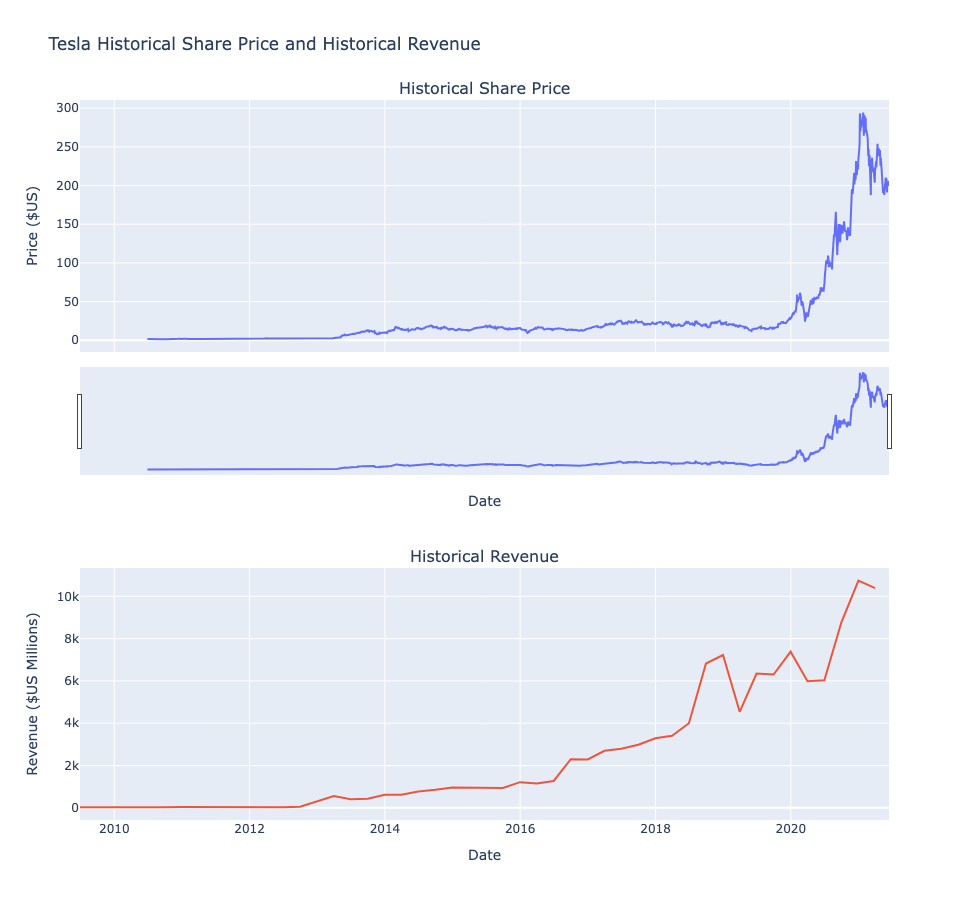

In [18]:
make_graph(tesla_data, tesla_revenue, 'Tesla Historical Share Price and Historical Revenue')


<h1>Question 6: Plot GameStop Stock Graph

Use the ```make_graph``` function to graph the GameStop Stock Data, also provide a title for the graph.


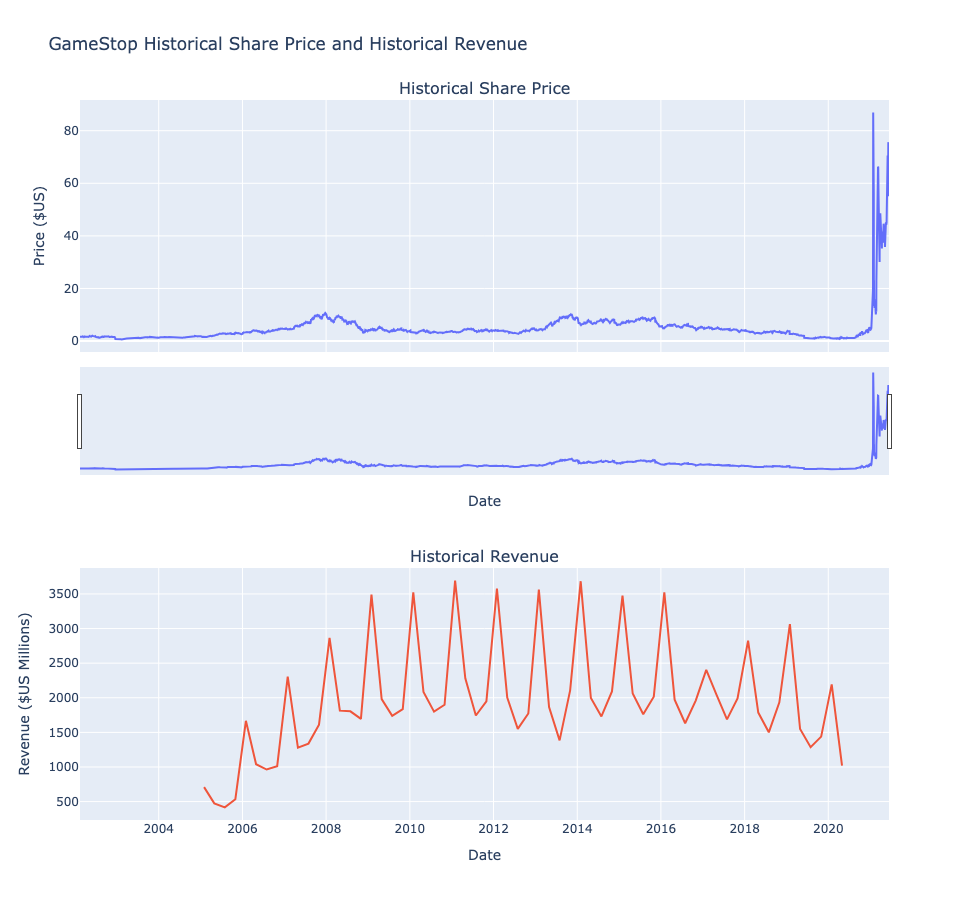

In [19]:
make_graph(gme_data, gme_revenue, 'GameStop Historical Share Price and Historical Revenue')